# Imports

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms,datasets
import torch
import bcolz
import time
%matplotlib inline

In [2]:
!pip install bcolz

    100% |████████████████████████████████| 1.5MB 24.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for bcolz ... done
  Stored in directory: /home/foodlovers/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz


In [3]:
import imp
import utils; imp.reload(utils)
from utils import *

GPU test

In [10]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: True 


In [ ]:
a = torch.tensor(2)
a.cuda()

In [15]:
use_gpu =  False

# Data process

In [4]:
# data_dir = 'D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_Food101\\images'
data_dir = '/home/foodlovers/FoodVisor/data/images'

In [5]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep1)
         for x in ['train', 'test']}

In [6]:
len(dsets['train'].classes)

101

In [7]:
dsets['train'].class_to_idx

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

In [8]:
dsets['train'].imgs[:5]

[('/home/foodlovers/FoodVisor/data/images/train/apple_pie/apple_pie_0.jpg', 0),
 ('/home/foodlovers/FoodVisor/data/images/train/apple_pie/apple_pie_100.jpg',
  0),
 ('/home/foodlovers/FoodVisor/data/images/train/apple_pie/apple_pie_101.jpg',
  0),
 ('/home/foodlovers/FoodVisor/data/images/train/apple_pie/apple_pie_102.jpg',
  0),
 ('/home/foodlovers/FoodVisor/data/images/train/apple_pie/apple_pie_104.jpg',
  0)]

In [6]:
dset_classes = dsets['train'].classes

In [6]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 67988, 'test': 22716}

Dataset loaders

In [7]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=128,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'test']}

In [12]:
dataset_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=True, num_workers=6)

In [13]:
len(dataset_valid)

4544

In [14]:
count = 0
for data in dataset_valid:
    if count == 0:
        inputs_try,labels_try = data
    else:
        break
    count += 1

In [15]:
labels_try

tensor([44, 83, 38,  5, 15])

In [16]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


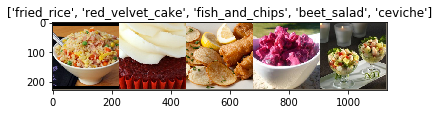

In [17]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


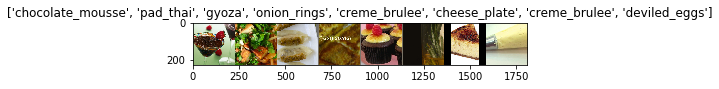

In [18]:
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


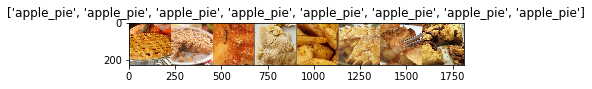

In [19]:
# Get a batch of validation data
inputs, classes = next(iter(dset_loaders['test']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

# Creating VGG Model

In [8]:
model_vgg = models.vgg16(pretrained=True)

In [21]:
inputs_try , labels_try = var_cgpu(inputs_try,use_gpu),var_cgpu(labels_try,use_gpu)

if use_gpu:
    model_vgg = model_vgg.cuda()

In [22]:
outputs_try = model_vgg(inputs_try)

In [23]:
outputs_try

tensor([[-3.9744e+00,  9.9007e-02, -5.1416e+00,  ..., -1.0312e-03,
          8.2446e+00,  2.4987e+00],
        [-5.2713e-03,  1.1657e+00, -1.5175e+00,  ...,  7.6675e-01,
          6.0787e+00,  2.6641e+00],
        [-8.8643e-01, -1.1893e+00, -4.6193e+00,  ...,  5.4745e+00,
          7.4802e+00,  1.6731e+00],
        [-4.8675e+00, -2.3513e+00, -2.3100e+00,  ...,  2.7843e-01,
          5.2333e+00,  1.1180e+00],
        [-2.8037e+00,  3.5781e+00, -3.8849e+00,  ...,  3.4804e+00,
          7.8234e+00,  1.7680e+00]], device='cuda:0', grad_fn=<AddmmBackward>)

In [24]:
outputs_try.shape

torch.Size([5, 1000])

### Modifying the last layer and setting the gradient false to all layers

In [12]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 101)

In [27]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=101, bias=True)
)


In [10]:
if use_gpu:
    model_vgg = model_vgg.cuda()

## Calculating preconvoluted features

In [11]:
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    count = 1
    for data in dataset:
        print(count,"/",len(dataset))
        count += 1
        inputs,labels = data
        if use_gpu:
            inputs , labels = Variable(inputs.cuda()),Variable(labels.cuda())
        else:
            inputs , labels = Variable(inputs),Variable(labels)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [12]:
%%time
conv_feat_train,labels_train = preconvfeat(dset_loaders['train'])

1 / 532
2 / 532
3 / 532
4 / 532
5 / 532
6 / 532
7 / 532
8 / 532
9 / 532
10 / 532
11 / 532
12 / 532
13 / 532
14 / 532
15 / 532
16 / 532
17 / 532
18 / 532
19 / 532
20 / 532
21 / 532
22 / 532
23 / 532
24 / 532
25 / 532
26 / 532
27 / 532
28 / 532
29 / 532
30 / 532
31 / 532
32 / 532
33 / 532
34 / 532
35 / 532
36 / 532
37 / 532
38 / 532
39 / 532
40 / 532
41 / 532
42 / 532
43 / 532
44 / 532
45 / 532
46 / 532
47 / 532
48 / 532
49 / 532
50 / 532
51 / 532
52 / 532
53 / 532
54 / 532
55 / 532
56 / 532
57 / 532
58 / 532
59 / 532
60 / 532
61 / 532
62 / 532
63 / 532
64 / 532
65 / 532
66 / 532
67 / 532
68 / 532
69 / 532
70 / 532
71 / 532
72 / 532
73 / 532
74 / 532
75 / 532
76 / 532
77 / 532
78 / 532
79 / 532
80 / 532
81 / 532
82 / 532
83 / 532
84 / 532
85 / 532
86 / 532
87 / 532
88 / 532
89 / 532
90 / 532
91 / 532
92 / 532
93 / 532
94 / 532
95 / 532
96 / 532
97 / 532
98 / 532
99 / 532
100 / 532
101 / 532
102 / 532
103 / 532
104 / 532
105 / 532
106 / 532
107 / 532
108 / 532
109 / 532
110 / 532
111 / 53

/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

120 / 532
121 / 532
122 / 532
123 / 532
124 / 532
125 / 532
126 / 532
127 / 532
128 / 532
129 / 532
130 / 532
131 / 532
132 / 532
133 / 532
134 / 532
135 / 532
136 / 532
137 / 532
138 / 532
139 / 532
140 / 532
141 / 532
142 / 532
143 / 532
144 / 532
145 / 532
146 / 532
147 / 532
148 / 532
149 / 532
150 / 532
151 / 532
152 / 532
153 / 532
154 / 532
155 / 532
156 / 532
157 / 532
158 / 532
159 / 532
160 / 532
161 / 532
162 / 532
163 / 532
164 / 532
165 / 532
166 / 532
167 / 532
168 / 532
169 / 532
170 / 532
171 / 532
172 / 532
173 / 532
174 / 532
175 / 532
176 / 532
177 / 532
178 / 532
179 / 532
180 / 532
181 / 532
182 / 532
183 / 532
184 / 532
185 / 532
186 / 532
187 / 532
188 / 532
189 / 532
190 / 532
191 / 532
192 / 532
193 / 532
194 / 532
195 / 532
196 / 532
197 / 532
198 / 532
199 / 532
200 / 532
201 / 532
202 / 532
203 / 532
204 / 532
205 / 532
206 / 532
207 / 532
208 / 532
209 / 532
210 / 532
211 / 532
212 / 532
213 / 532
214 / 532
215 / 532
216 / 532
217 / 532
218 / 532
219 / 532


In [13]:
%%time
conv_feat_val,labels_val = preconvfeat(dset_loaders['test'])

1 / 178
2 / 178
3 / 178
4 / 178
5 / 178
6 / 178
7 / 178
8 / 178
9 / 178
10 / 178
11 / 178
12 / 178
13 / 178
14 / 178
15 / 178
16 / 178
17 / 178
18 / 178
19 / 178
20 / 178
21 / 178
22 / 178
23 / 178
24 / 178
25 / 178
26 / 178
27 / 178
28 / 178
29 / 178
30 / 178
31 / 178
32 / 178
33 / 178
34 / 178
35 / 178
36 / 178
37 / 178
38 / 178
39 / 178
40 / 178
41 / 178
42 / 178
43 / 178
44 / 178
45 / 178
46 / 178
47 / 178
48 / 178
49 / 178
50 / 178
51 / 178
52 / 178
53 / 178
54 / 178
55 / 178
56 / 178
57 / 178
58 / 178
59 / 178
60 / 178
61 / 178
62 / 178
63 / 178
64 / 178
65 / 178
66 / 178
67 / 178
68 / 178
69 / 178
70 / 178
71 / 178
72 / 178
73 / 178
74 / 178
75 / 178
76 / 178
77 / 178
78 / 178
79 / 178
80 / 178
81 / 178
82 / 178
83 / 178
84 / 178
85 / 178
86 / 178
87 / 178
88 / 178
89 / 178
90 / 178
91 / 178
92 / 178
93 / 178
94 / 178
95 / 178
96 / 178
97 / 178
98 / 178
99 / 178
100 / 178
101 / 178
102 / 178
103 / 178
104 / 178
105 / 178
106 / 178
107 / 178
108 / 178
109 / 178
110 / 178
111 / 17

### Save extracted features

In [22]:
save_array('/home/foodlovers/vgg16/conv_feat_train.bc',conv_feat_train)
save_array('/home/foodlovers/vgg16/labels_train.bc',labels_train)
save_array('/home/foodlovers/vgg16/conv_feat_val.bc',conv_feat_val)
save_array('/home/foodlovers/vgg16/labels_val.bc',labels_val)

### Load extracted features

In [103]:
conv_feat_train = load_array('/home/foodlovers/vgg16/conv_feat_train.bc')
labels_train = load_array('/home/foodlovers/vgg16/labels_train.bc')
conv_feat_val = load_array('/home/foodlovers/vgg16/conv_feat_val.bc')
labels_val = load_array('/home/foodlovers/vgg16/labels_val.bc')

In [104]:
conv_feat_train.shape

(67988, 512, 7, 7)

### Try with a classifier

In [107]:
X_train = conv_feat_train.reshape((conv_feat_train.shape[0],-1))
X_test = conv_feat_val.reshape((conv_feat_val.shape[0],-1))

In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train, labels_train)

In [ ]:
print ("Predict on test data ... ")
y_pred = clf.predict(X_test)
accuracy = accuracy_score(labels_val, y_pred)
print("Accuracy : ", accuracy)

## Training fully connected module

### Creating loss function and optimizer

In [34]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Creating Data generator

In [15]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(labels))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(labels),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size],int(len(labels) / batch_size) + (len(labels) % batch_size > 0))

### Training the model

In [13]:
def train_model(model,size,conv_feat=None,labels=None,epochs=1,optimizer=None,train=True,shuffle=True):
    loss_history = []
    acc_history = []
    
    if train:
        model.train()
    else:
        model.eval()
        
    for epoch in range(epochs):
        batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes,_ in batches:
            if use_gpu:
                inputs , classes = torch.from_numpy(inputs).cuda(), torch.from_numpy(classes).cuda()
            else:
                inputs , classes = torch.from_numpy(inputs), torch.from_numpy(classes)
                
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs,classes)           
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
                optimizer = optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
        
        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)
        
    return loss_history,acc_history
    

In [45]:
%%time
losses_hist, acc_hist = train_model(model=model_vgg.classifier,size=dset_sizes['train'],conv_feat=conv_feat_train,labels=labels_train,
            epochs=10,optimizer=optimizer_vgg,train=True,shuffle=True)

Loss: 0.0353 Acc: 0.4379
Loss: 0.0352 Acc: 0.4395
Loss: 0.0352 Acc: 0.4382
Loss: 0.0352 Acc: 0.4371
Loss: 0.0352 Acc: 0.4389
Loss: 0.0351 Acc: 0.4386
Loss: 0.0352 Acc: 0.4369
Loss: 0.0352 Acc: 0.4381
Loss: 0.0351 Acc: 0.4399
Loss: 0.0352 Acc: 0.4384
CPU times: user 1min 46s, sys: 54.3 s, total: 2min 41s
Wall time: 2min 41s


### Validation

In [46]:
train_model(conv_feat=conv_feat_val,labels=labels_val,model=model_vgg.classifier
            ,size=dset_sizes['test'],train=False,shuffle=False)

Loss: 0.0377 Acc: 0.4333


([0.03767249714186293], [0.4333069202324353])

### Plot loss & accuracy history

Text(0.5, 1.0, 'Loss history')

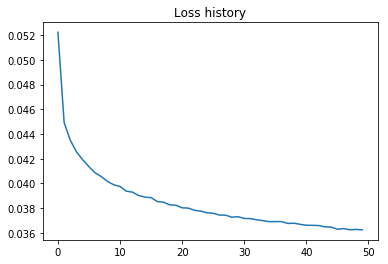

In [39]:
plt.plot(losses_hist)
plt.title("Loss history")

Text(0.5, 1.0, 'Training accuracy history')

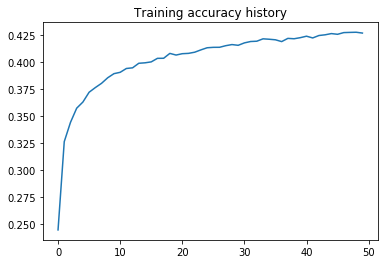

In [40]:
plt.plot(acc_hist)
plt.title("Training accuracy history")

## Fine tune more parameters

In [5]:
model_vgg = models.vgg16(pretrained=True)

In [6]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
model_vgg.classifier._modules['6'] = nn.Linear(4096, 101)

In [8]:
for param in model_vgg.features.parameters():
    param.requires_grad = False

In [11]:
if use_gpu:
    model_vgg = model_vgg.cuda()

### Loss & Optim

In [12]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_vgg = torch.optim.SGD(model_vgg.classifier.parameters(),lr = lr)

### Training

In [81]:
def train_model_2(model, criterion,
                 train_data = None, train_labels = None,
                 test_data = None, test_labels = None,
                  optimizer = None,
                 epochs = 1,train = True, validate = False,
                shuffle = True) :
    
    if train == True :
        loss_history = []
        acc_history = []
        val_loss_history = []
        val_acc_history = []
        
    for epoch in range(epochs) :
        if train == True :
            #=========================TRAINING=================================#
            start_time_epoch = time.time()
            
            model.train()
    
            print("Epoch:", epoch,"/",epochs-1,"===============================================")
        
            running_loss = 0.0
            running_corrects = 0.0
            
            batches = data_gen(conv_feat=train_data,labels=train_labels,shuffle=shuffle)
            
            #batch_num = len(list(batches))

            for i,data in enumerate(batches) :
                start_time = time.time()
        
                inputs,classes,batch_num = data

                if  isinstance(inputs, (list, np.ndarray)) :
                    inputs , classes = torch.from_numpy(inputs), torch.from_numpy(classes)

                if use_gpu:
                    inputs , classes = inputs.cuda(), classes.cuda()

                inputs = inputs.view(inputs.size(0), -1)
                    
                # calulate outputs and losses
                outputs = model(inputs)
                loss = criterion(outputs,classes)       

                # autograd
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # statistics
                batch_loss = loss.data.item()
                _,preds = torch.max(outputs.data,1)
                batch_corrects = torch.sum(preds == classes.data)
                
                running_loss += batch_loss
                running_corrects += batch_corrects

                print('Batch {:d}/{:d} - Loss: {:.4f} Acc: {:.4f} - Time : {:.2f}s'.format(i+1,batch_num,
                             batch_loss/len(classes), float(batch_corrects)/len(classes), time.time() - start_time),end='\r')

            epoch_loss = running_loss / len(train_labels)
            epoch_acc = running_corrects.data.item() / len(train_labels)
            #
            
            loss_history.append(epoch_loss)
            acc_history.append(epoch_acc)
            
            print('Epoch {:d} completed in {:.2f} seconds ! Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch , time.time() - start_time_epoch, epoch_loss, epoch_acc))
            
        if validate == True :
            #=========================VALIDATING=================================#
            
            model.eval()
            
            val_loss = 0.0
            val_corrects = 0.0
            
            batches = data_gen(conv_feat=test_data,labels=test_labels,shuffle=shuffle)
            
            #batch_num = len(list(batches))

            for i,data in enumerate(batches) :
                start_time = time.time()
                
                inputs,classes,batch_num = data
                
                if  isinstance(inputs, (list, np.ndarray)) :
                    inputs , classes = torch.from_numpy(inputs), torch.from_numpy(classes)

                if use_gpu:
                    inputs , classes = inputs.cuda(), classes.cuda()
                    
                inputs = inputs.view(inputs.size(0), -1)

                outputs = model(inputs)
                loss = criterion(outputs,classes)        
                _,preds = torch.max(outputs.data,1)

                # statistics

                val_loss += loss.data.item()
                val_corrects += torch.sum(preds == classes.data)
                
                print('Validating batch {:d}/{:d} - {:.2f}s ...'.format(i+1,batch_num
                                                                , time.time() - start_time), end="\r")

            val_epoch_loss = val_loss / len(test_labels)
            val_epoch_acc = val_corrects.data.item() / len(test_labels)
            # 

            print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(
                             val_epoch_loss,val_epoch_acc))
            
            if train == False :
                return
            else :
                val_loss_history.append(val_epoch_loss)
                val_acc_history.append(val_epoch_acc)
    
    if train == False :
        return 'On fait rien!'
    elif validate == False :
        return loss_history, acc_history
    else :
        return loss_history, acc_history,val_loss_history,val_acc_history

In [16]:
history = train_model_2(model=model_vgg.classifier,criterion=criterion,
              train_data = conv_feat_train, train_labels = labels_train,
                 test_data = conv_feat_val, test_labels = labels_val,
                  optimizer = optimizer_vgg,
                 epochs = 10,train = True, validate = True,
                shuffle = True)

Epoch: 0 / 10 ===============================================
Epoch 0 completed in 48.56 seconds ! Loss: 0.0494 Acc: 0.2680
Val Loss: 0.0414 Val Acc: 0.3765 ...
Epoch: 1 / 10 ===============================================
Epoch 1 completed in 48.23 seconds ! Loss: 0.0408 Acc: 0.3756
Val Loss: 0.0389 Val Acc: 0.4082 ...
Epoch: 2 / 10 ===============================================
Epoch 2 completed in 48.68 seconds ! Loss: 0.0371 Acc: 0.4255
Val Loss: 0.0376 Val Acc: 0.4249 ...
Epoch: 3 / 10 ===============================================
Epoch 3 completed in 48.83 seconds ! Loss: 0.0341 Acc: 0.4655
Val Loss: 0.0367 Val Acc: 0.4413 ...
Epoch: 4 / 10 ===============================================
Epoch 4 completed in 48.96 seconds ! Loss: 0.0312 Acc: 0.5064
Val Loss: 0.0358 Val Acc: 0.4538 ...
Epoch: 5 / 10 ===============================================
Epoch 5 completed in 48.77 seconds ! Loss: 0.0285 Acc: 0.5446
Val Loss: 0.0354 Val Acc: 0.4605 ...
Epoch: 6 / 10 ====================

In [17]:
history_2 = train_model_2(model=model_vgg.classifier,criterion=criterion,
              train_data = conv_feat_train, train_labels = labels_train,
                 test_data = conv_feat_val, test_labels = labels_val,
                  optimizer = optimizer_vgg,
                 epochs = 10,train = True, validate = True,
                shuffle = True)

Epoch: 0 / 10 ===============================================
Epoch 0 completed in 48.81 seconds ! Loss: 0.0157 Acc: 0.7377
Val Loss: 0.0357 Val Acc: 0.4811 ...
Epoch: 1 / 10 ===============================================
Epoch 1 completed in 48.84 seconds ! Loss: 0.0135 Acc: 0.7735
Val Loss: 0.0362 Val Acc: 0.4841 ...
Epoch: 2 / 10 ===============================================
Epoch 2 completed in 48.93 seconds ! Loss: 0.0115 Acc: 0.8055
Val Loss: 0.0368 Val Acc: 0.4819 ...
Epoch: 3 / 10 ===============================================
Epoch 3 completed in 48.72 seconds ! Loss: 0.0097 Acc: 0.8383
Val Loss: 0.0373 Val Acc: 0.4824 ...
Epoch: 4 / 10 ===============================================
Epoch 4 completed in 48.95 seconds ! Loss: 0.0082 Acc: 0.8606
Val Loss: 0.0382 Val Acc: 0.4843 ...
Epoch: 5 / 10 ===============================================
Epoch 5 completed in 48.98 seconds ! Loss: 0.0069 Acc: 0.8853
Val Loss: 0.0392 Val Acc: 0.4833 ...
Epoch: 6 / 10 ====================

In [18]:
for i in range(4):
    history[i].extend(history_2[i])

### Validation

In [20]:
train_model_2(model=model_vgg.classifier,criterion=criterion,
              train_data = conv_feat_train, train_labels = labels_train,
                 test_data = conv_feat_val, test_labels = labels_val,
                  optimizer = optimizer_vgg,
                 epochs = 10,train = False, validate = True,
                shuffle = True)

Val Loss: 0.0417 Val Acc: 0.4842 ...


### Plots

Text(0.5, 1.0, 'Loss history')

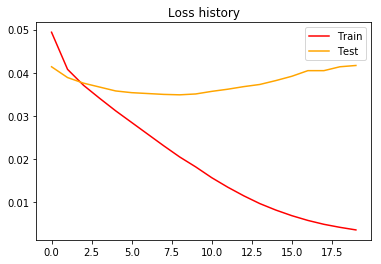

In [32]:
plt.plot(history[0], color ='red', label = 'Train')
plt.plot(history[2], color ='orange', label = 'Test')
plt.legend()
plt.plot()
plt.title("Loss history")

Text(0.5, 1.0, 'Accuracy history')

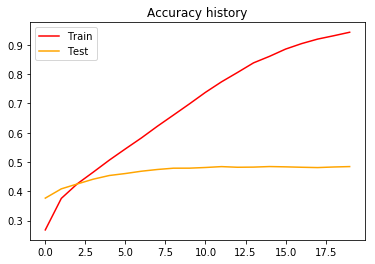

In [33]:
plt.plot(history[1], color ='red',label = 'Train')
plt.plot(history[3], color ='orange', label = 'Test')
plt.legend()
plt.plot()
plt.title("Accuracy history")

## Adding a (residual) layer

### Preprocess

In [35]:
data_dir = '/home/foodlovers/FoodVisor/data/images'

In [36]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep1)
         for x in ['train', 'test']}

In [37]:
dataset_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=True, num_workers=6)

for data in dataset_valid:
    inputs_try,labels_try = data
    break


In [39]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

In [48]:
out_try_avg = torch.nn.functional.avg_pool2d(inputs_try,kernel_size = 16)

In [49]:
out_try_avg.shape

torch.Size([5, 3, 14, 14])

In [50]:
out_try_avg= out_try_avg.view(out_try_avg.shape[0],-1)

In [51]:
out_try_avg.shape

torch.Size([5, 588])

In [47]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=128,
                                               shuffle=False, num_workers=6)
                for x in ['train', 'test']}

In [53]:
x = model_vgg.features(inputs_try.cuda())

In [73]:
C = []

In [74]:
x = model_vgg.features(inputs_try.cuda())
x = x.view(x.shape[0],-1)
y = nn.functional.avg_pool2d(inputs_try.cuda(),kernel_size = 16)
y = y.view(y.shape[0],-1)
print(x.shape)
C.extend(np.concatenate([x.data.cpu().numpy(),y.data.cpu().numpy()],axis = 1))

torch.Size([5, 25088])


### Compute features

In [76]:
def preconvfeat_2(dataset):
    conv_features = []
    labels_list = []
    count = 1
    for data in dataset:
        print(count,"/",len(dataset))
        count += 1
        inputs,labels = data
        if use_gpu:
            inputs , labels = Variable(inputs.cuda()),Variable(labels.cuda())
        else:
            inputs , labels = Variable(inputs),Variable(labels)
        
        x = model_vgg.features(inputs)
        x = x.view(x.shape[0],-1)
        y = nn.functional.avg_pool2d(inputs,kernel_size = 16)
        y = y.view(y.shape[0],-1)
        conv_features.extend(np.concatenate([x.data.cpu().numpy(),y.data.cpu().numpy()],axis = 1))
        labels_list.extend(labels.data.cpu().numpy())
    # conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [78]:
%%time
conv_feat_train,labels_train = preconvfeat_2(dset_loaders['train'])

1 / 532
2 / 532
3 / 532
4 / 532
5 / 532
6 / 532
7 / 532
8 / 532
9 / 532
10 / 532
11 / 532
12 / 532
13 / 532
14 / 532
15 / 532
16 / 532
17 / 532
18 / 532
19 / 532
20 / 532
21 / 532
22 / 532
23 / 532
24 / 532
25 / 532
26 / 532
27 / 532
28 / 532
29 / 532
30 / 532
31 / 532
32 / 532
33 / 532
34 / 532
35 / 532
36 / 532
37 / 532
38 / 532
39 / 532
40 / 532
41 / 532
42 / 532
43 / 532
44 / 532
45 / 532
46 / 532
47 / 532
48 / 532
49 / 532
50 / 532
51 / 532
52 / 532
53 / 532
54 / 532
55 / 532
56 / 532
57 / 532
58 / 532
59 / 532
60 / 532
61 / 532
62 / 532
63 / 532
64 / 532
65 / 532
66 / 532
67 / 532
68 / 532
69 / 532
70 / 532
71 / 532
72 / 532
73 / 532
74 / 532
75 / 532
76 / 532
77 / 532
78 / 532
79 / 532
80 / 532
81 / 532
82 / 532
83 / 532
84 / 532
85 / 532
86 / 532
87 / 532
88 / 532
89 / 532
90 / 532
91 / 532
92 / 532
93 / 532
94 / 532
95 / 532
96 / 532
97 / 532
98 / 532
99 / 532
100 / 532
101 / 532
102 / 532
103 / 532
104 / 532
105 / 532
106 / 532
107 / 532
108 / 532
109 / 532
110 / 532
111 / 53

/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

138 / 532
139 / 532
140 / 532
141 / 532
142 / 532
143 / 532
144 / 532
145 / 532
146 / 532
147 / 532
148 / 532
149 / 532
150 / 532
151 / 532
152 / 532
153 / 532
154 / 532
155 / 532
156 / 532
157 / 532
158 / 532
159 / 532
160 / 532
161 / 532
162 / 532
163 / 532
164 / 532
165 / 532
166 / 532
167 / 532
168 / 532
169 / 532
170 / 532
171 / 532
172 / 532
173 / 532
174 / 532
175 / 532
176 / 532
177 / 532
178 / 532
179 / 532
180 / 532
181 / 532
182 / 532
183 / 532
184 / 532
185 / 532
186 / 532
187 / 532
188 / 532
189 / 532
190 / 532
191 / 532
192 / 532
193 / 532
194 / 532
195 / 532
196 / 532
197 / 532
198 / 532
199 / 532
200 / 532
201 / 532
202 / 532
203 / 532
204 / 532
205 / 532
206 / 532
207 / 532
208 / 532
209 / 532
210 / 532
211 / 532
212 / 532
213 / 532
214 / 532
215 / 532
216 / 532
217 / 532
218 / 532
219 / 532
220 / 532
221 / 532
222 / 532
223 / 532
224 / 532
225 / 532
226 / 532
227 / 532
228 / 532
229 / 532
230 / 532
231 / 532
232 / 532
233 / 532
234 / 532
235 / 532
236 / 532
237 / 532


In [79]:
%%time
conv_feat_val,labels_val = preconvfeat_2(dset_loaders['test'])

1 / 178
2 / 178
3 / 178
4 / 178
5 / 178
6 / 178
7 / 178
8 / 178
9 / 178
10 / 178
11 / 178
12 / 178
13 / 178
14 / 178
15 / 178
16 / 178
17 / 178
18 / 178
19 / 178
20 / 178
21 / 178
22 / 178
23 / 178
24 / 178
25 / 178
26 / 178
27 / 178
28 / 178
29 / 178
30 / 178
31 / 178
32 / 178
33 / 178
34 / 178
35 / 178
36 / 178
37 / 178
38 / 178
39 / 178
40 / 178
41 / 178
42 / 178
43 / 178
44 / 178
45 / 178
46 / 178
47 / 178
48 / 178
49 / 178
50 / 178
51 / 178
52 / 178
53 / 178
54 / 178
55 / 178
56 / 178
57 / 178
58 / 178
59 / 178
60 / 178
61 / 178
62 / 178
63 / 178
64 / 178
65 / 178
66 / 178
67 / 178
68 / 178
69 / 178
70 / 178
71 / 178
72 / 178
73 / 178
74 / 178
75 / 178
76 / 178
77 / 178
78 / 178
79 / 178
80 / 178
81 / 178
82 / 178
83 / 178
84 / 178
85 / 178
86 / 178
87 / 178
88 / 178
89 / 178
90 / 178
91 / 178
92 / 178
93 / 178
94 / 178
95 / 178
96 / 178
97 / 178
98 / 178
99 / 178
100 / 178
101 / 178
102 / 178
103 / 178
104 / 178
105 / 178
106 / 178
107 / 178
108 / 178
109 / 178
110 / 178
111 / 17

In [85]:
len(conv_feat_train[0])

25676

In [99]:
conv_feat_train = np.concatenate([[feat] for feat in conv_feat_train])

In [96]:
conv_feat_val = np.concatenate([[feat] for feat in conv_feat_val])

In [80]:
model_vgg = models.vgg16(pretrained=True)

In [82]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [86]:
model_vgg.classifier._modules['0'] = nn.Linear(25676, 4096)
model_vgg.classifier._modules['6'] = nn.Linear(4096, 101)

In [87]:
for param in model_vgg.features.parameters():
    param.requires_grad = False

In [88]:
if use_gpu:
    model_vgg = model_vgg.cuda()

In [89]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_vgg = torch.optim.SGD(model_vgg.classifier.parameters(),lr = lr)

In [100]:
history = train_model_2(model=model_vgg.classifier,criterion=criterion,
              train_data = conv_feat_train, train_labels = labels_train,
                 test_data = conv_feat_val, test_labels = labels_val,
                  optimizer = optimizer_vgg,
                 epochs = 20,train = True, validate = True,
                shuffle = True)

Epoch: 0 / 19 ===============================================
Epoch 0 completed in 49.40 seconds ! Loss: 0.0701 Acc: 0.0329
Val Loss: 0.0594 Val Acc: 0.1111 ...
Epoch: 1 / 19 ===============================================
Epoch 1 completed in 49.86 seconds ! Loss: 0.0509 Acc: 0.2320
Val Loss: 0.0442 Val Acc: 0.3324 ...
Epoch: 2 / 19 ===============================================
Epoch 2 completed in 50.05 seconds ! Loss: 0.0415 Acc: 0.3601
Val Loss: 0.0410 Val Acc: 0.3741 ...
Epoch: 3 / 19 ===============================================
Epoch 3 completed in 50.28 seconds ! Loss: 0.0358 Acc: 0.4400
Val Loss: 0.0388 Val Acc: 0.4086 ...
Epoch: 4 / 19 ===============================================
Epoch 4 completed in 50.31 seconds ! Loss: 0.0306 Acc: 0.5128
Val Loss: 0.0374 Val Acc: 0.4324 ...
Epoch: 5 / 19 ===============================================
Epoch 5 completed in 50.33 seconds ! Loss: 0.0254 Acc: 0.5901
Val Loss: 0.0379 Val Acc: 0.4301 ...
Epoch: 6 / 19 ====================

Text(0.5, 1.0, 'Loss history')

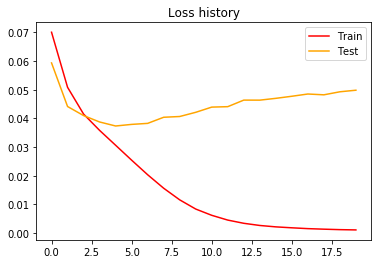

In [101]:
plt.plot(history[0], color ='red', label = 'Train')
plt.plot(history[2], color ='orange', label = 'Test')
plt.legend()
plt.plot()
plt.title("Loss history")

Text(0.5, 1.0, 'Accuracy history')

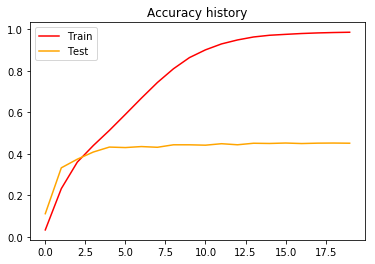

In [102]:
plt.plot(history[1], color ='red', label = 'Train')
plt.plot(history[3], color ='orange', label = 'Test')
plt.legend()
plt.plot()
plt.title("Accuracy history")